# Task B1

What is the distribution of note onsets on metrical locations? Answer this question separately for different time signatures. At least do 4/4 and 3/4 time signatures. Illustrate your finding with figures.

Subcorpus: https://github.com/fosfrancesco/asap-dataset/tree/master/Mozart/Piano_Sonatas

In [1]:
# Install dependencies
!pip install music21

In [2]:
# Import libraries
import os

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import music21
from music21 import midi, converter, meter, note, chord, pitch

In [3]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Change the path if necessary:
root_dir = '/content/drive/Shareddrives/dh401_digital_musicology/Mozart_Piano_Sonatas/'
os.chdir(root_dir)
!ls

11-3  12-1  12-2  12-3	8-1


---

## Onset distributions of unperfomed pieces with MusicXML files

In [5]:
def extract_onset_positions(filename):
    """
    Extracts the onset positions from a MusicXML file and the time signature.

    Parameters:
    - filename (str): The path to the MusicXML file.

    Returns:
    - pandas.Series: A pandas Series containing the onset positions.
    - str: The time signature of the piece.
    """
    # Parse the MusicXML file
    score = music21.converter.parse(filename)

    onset_positions = []
    # Iterate over notes and chords in the score
    for element in score.recurse().notesAndRests:
        onset_positions.append(round(float(element.offset), 2))

    # Extract time signature
    time_signature = score.flat.getElementsByClass(music21.meter.TimeSignature)[0].ratioString

    return pd.Series(onset_positions), time_signature

/usr/local/lib/python3.10/dist-packages/music21/stream/base.py:3694: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)


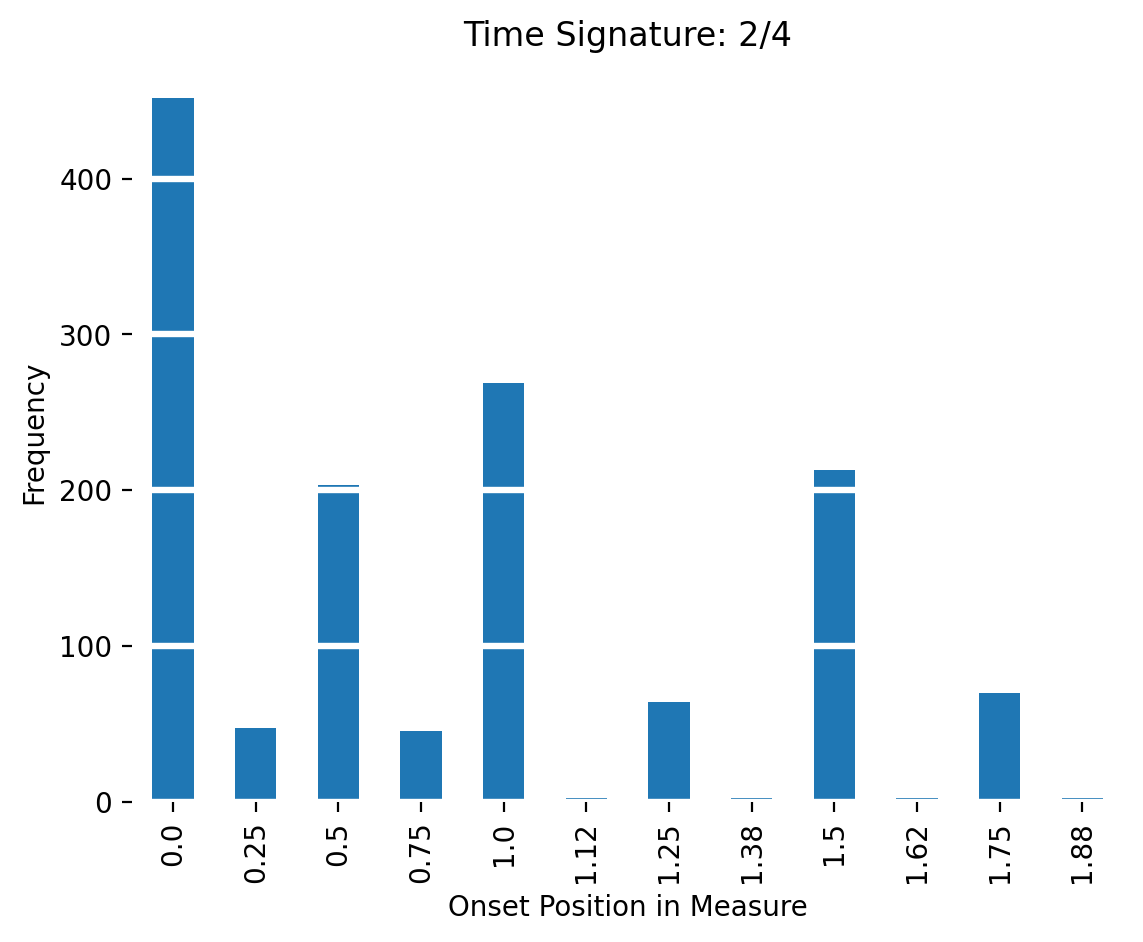

In [24]:
onset_positions, time_signature = extract_onset_positions(root_dir + '11-3/xml_score.musicxml')

onset_positions_counts = onset_positions.value_counts().sort_index()
onset_positions_counts.plot(kind='bar', color='#1F77B4')
plt.xlabel("Onset Position in Measure")
plt.ylabel("Frequency")
plt.title(f'Time Signature: {time_signature}')
plt.box(False)
plt.grid(axis='y', color='white', linewidth=2.3)
plt.show()

/usr/local/lib/python3.10/dist-packages/music21/stream/base.py:3694: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)


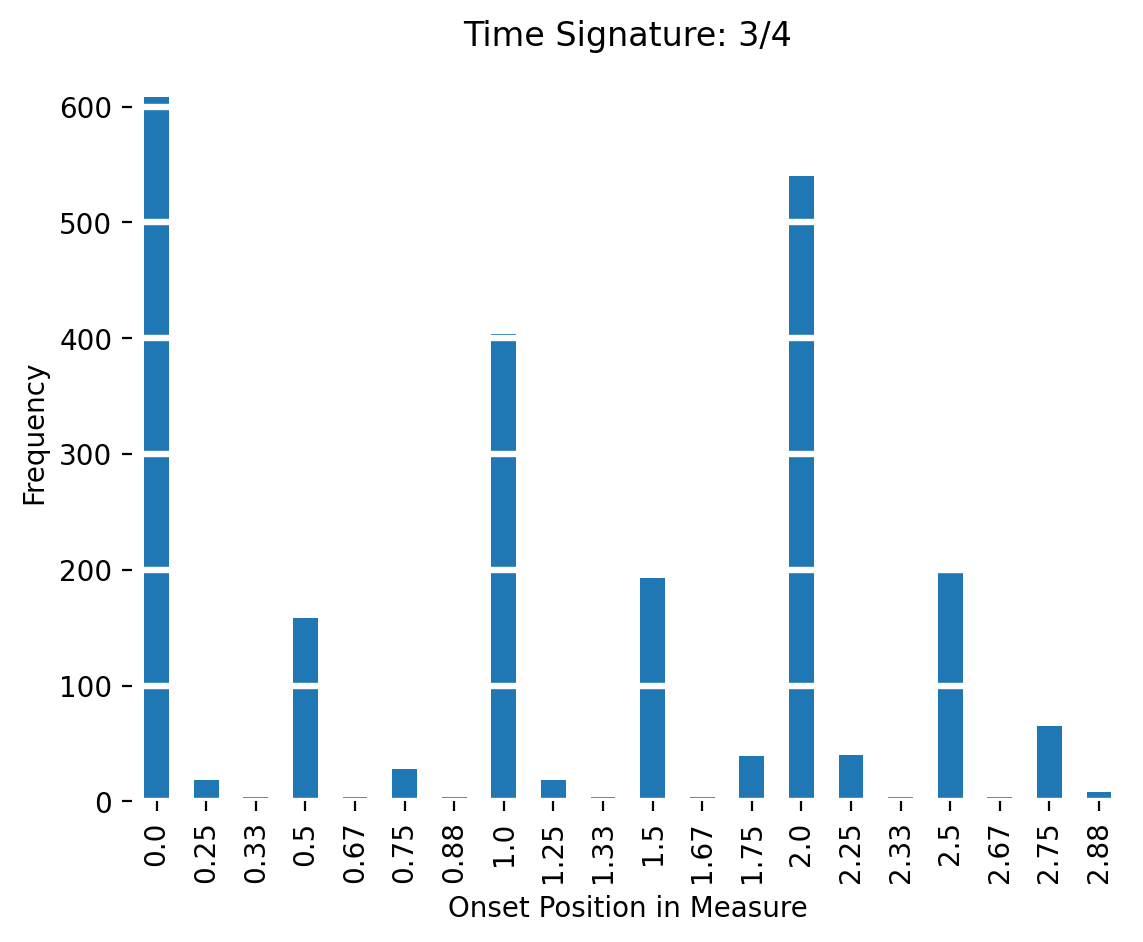

In [25]:
onset_positions, time_signature = extract_onset_positions(root_dir + '12-1/xml_score.musicxml')

onset_positions_counts = onset_positions.value_counts().sort_index()
onset_positions_counts.plot(kind='bar', color='#1F77B4')
plt.xlabel("Onset Position in Measure")
plt.ylabel("Frequency")
plt.title(f'Time Signature: {time_signature}')
plt.box(False)
plt.grid(axis='y', color='white', linewidth=2.3)
plt.show()

/usr/local/lib/python3.10/dist-packages/music21/stream/base.py:3694: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)


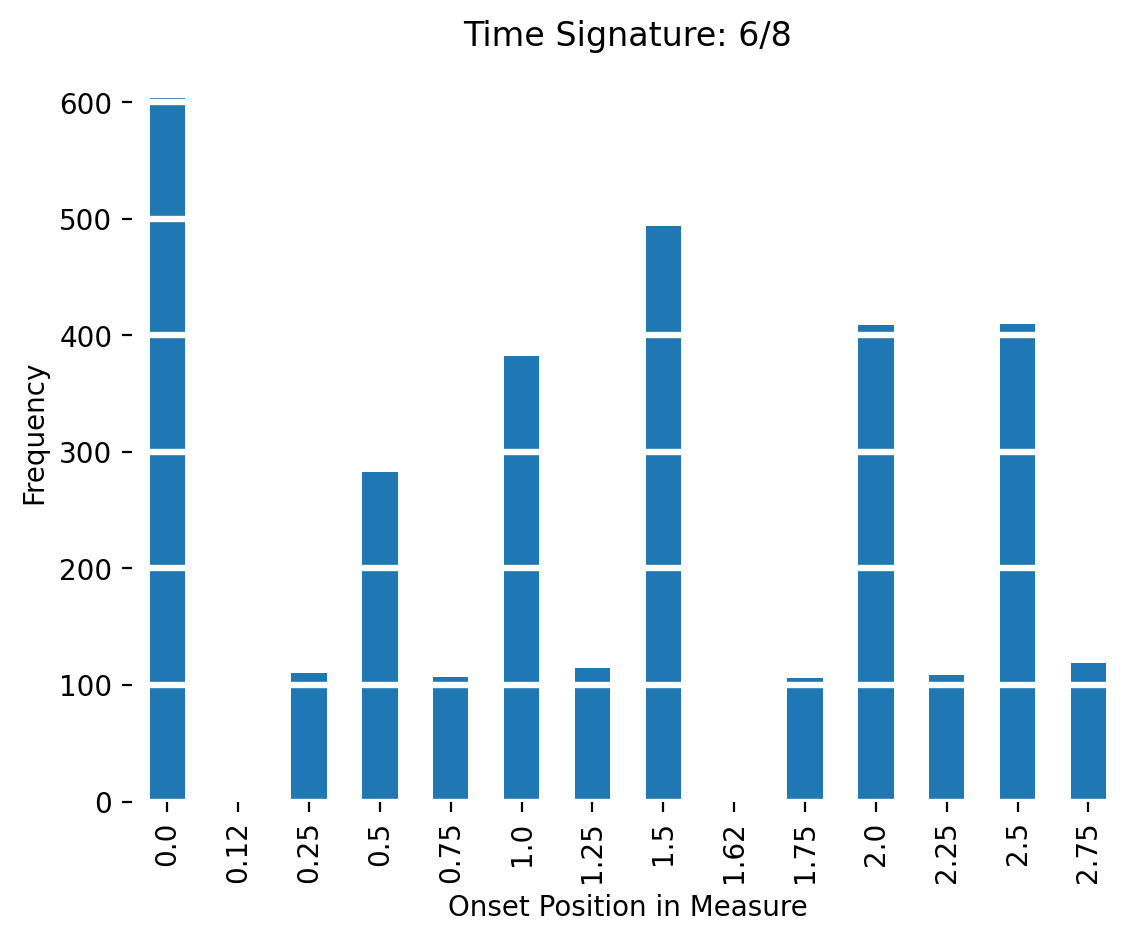

In [26]:
onset_positions, time_signature = extract_onset_positions(root_dir + '12-3/xml_score.musicxml')

# plt.figure(figsize=(12, 6))
onset_positions_counts = onset_positions.value_counts().sort_index()
onset_positions_counts.plot(kind='bar', color='#1F77B4')
plt.xlabel("Onset Position in Measure")
plt.ylabel("Frequency")
plt.title(f'Time Signature: {time_signature}')
plt.box(False)
plt.grid(axis='y', color='white', linewidth=2.3)
plt.show()

/usr/local/lib/python3.10/dist-packages/music21/stream/base.py:3694: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)


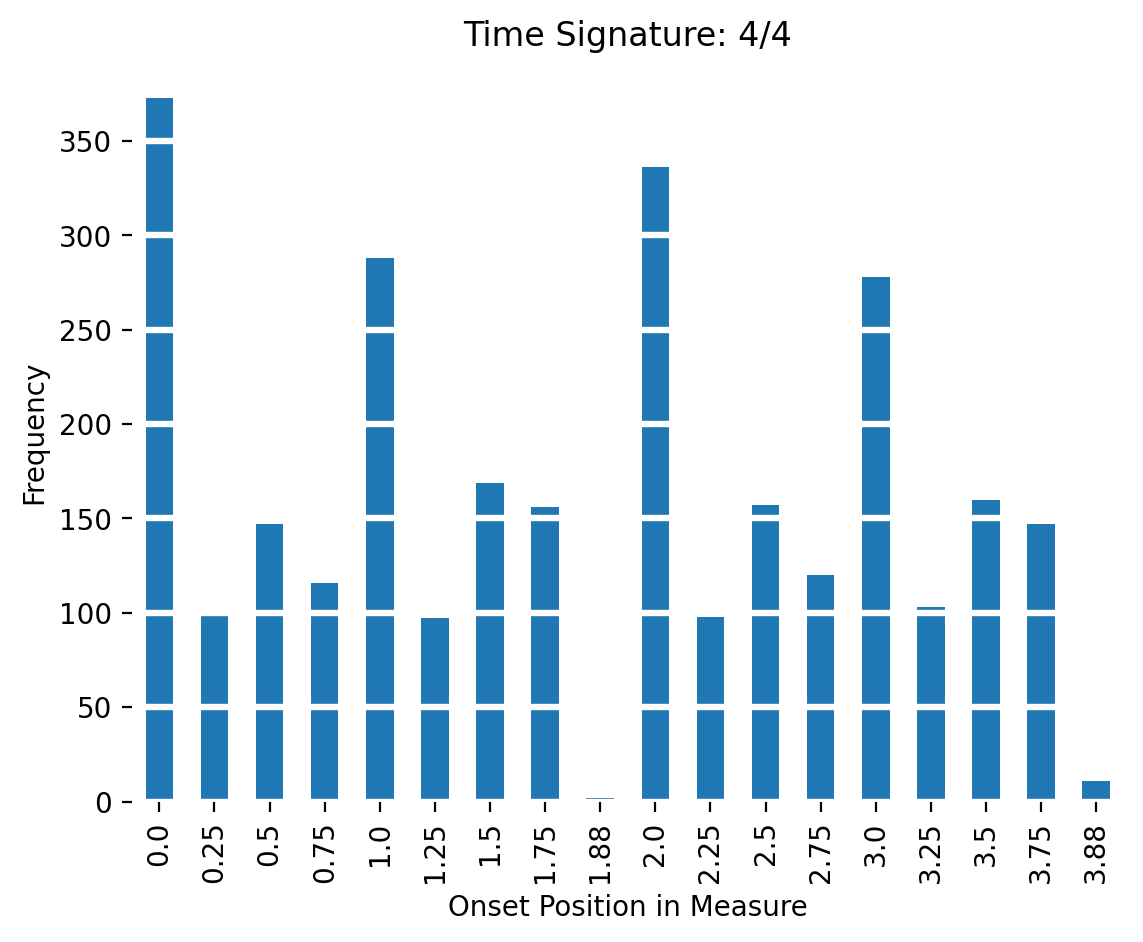

In [27]:
onset_positions, time_signature = extract_onset_positions(root_dir + '8-1/xml_score.musicxml')

# plt.figure(figsize=(12, 6))
onset_positions_counts = onset_positions.value_counts().sort_index()
onset_positions_counts.plot(kind='bar', color='#1F77B4')
plt.xlabel("Onset Position in Measure")
plt.ylabel("Frequency")
plt.title(f'Time Signature: {time_signature}')
plt.box(False)
plt.grid(axis='y', color='white', linewidth=2.3)
plt.show()

---

## Onset distributions of performed pieces with MIDI files

In [10]:
def load_mid_files(root_dir):
    """
    Load MIDI files from subfolders in the root directory.

    Parameters:
    - root_dir (str): Path to the root directory containing subfolders.

    Returns:
    - midi_files (dict): A dictionary containing loaded MIDI files grouped by subfolder name.
    """

    midi_files = {}

    # Traverse each subfolder in the root directory
    for subfolder in os.listdir(root_dir):
        subfolder_path = os.path.join(root_dir, subfolder)
        if os.path.isdir(subfolder_path):
            # Initialize dictionary entry for the subfolder
            midi_files[subfolder] = {}
            # Traverse MIDI files in the subfolder
            for filename in os.listdir(subfolder_path):
                if filename.endswith('.mid'):
                    file_path = os.path.join(subfolder_path, filename)
                    # Add MIDI file to dictionary
                    midi_files[subfolder][filename] = file_path

    return midi_files

In [11]:
def helpers_simplify_score_for_rhythm_analysis(sample_score_tmp):

    # remove chord charts, metronome mark, dynamics
    for part in sample_score_tmp.parts:
        for measure in part.getElementsByClass('Measure'):
            for event in measure:
                if isinstance(event, music21.harmony.ChordSymbol):
                    measure.remove(event)
                if isinstance(event, music21.tempo.MetronomeMark):
                    measure.remove(event)
                if isinstance(event, music21.dynamics.Dynamic):
                    measure.remove(event)
                if isinstance(event, music21.key.KeySignature):
                    measure.remove(event)

    # combine voice tracks intra-staff (done by extracted staffs and recombining)
    chordified_treble = sample_score_tmp.parts[0].chordify()
    sample_score = music21.stream.Score()
    sample_score.insert(0, chordified_treble)

    # cast all single-note chord objects (created by chordify) as note objects so students see more typical music21 score object structure
    staff_count = 0
    for part in sample_score.parts:
        staff_count += 1
        for measure in part.getElementsByClass('Measure'):
            for event in measure:
                if isinstance(event, music21.chord.Chord): # and len(event.notes) == 1:
                    note_version = music21.note.Note()
                    if staff_count == 1:
                        note_version.pitch = music21.pitch.Pitch('C4')
                    elif staff_count == 2:
                        note_version.pitch = music21.pitch.Pitch('C3')
                    note_version.duration = event.duration
                    start_found = 0
                    continue_found = 0
                    none_found = 0
                    all_ties_stop = 1
                    for nte in event.notes:
                        try:
                            curr_tie_obj = nte.tie.type
                        except:
                            curr_tie_obj = None
                        if (curr_tie_obj == 'start'):
                            start_found = 1
                        if (curr_tie_obj == 'continue'):
                            continue_found = 1
                        if (curr_tie_obj is None):
                            none_found = 1
                        if (curr_tie_obj != 'stop'):
                            all_ties_stop = 0
                    if start_found == 1:
                        note_version.tie = music21.tie.Tie('start')
                    elif none_found == 1:
                        note_version.tie = None
                    elif all_ties_stop == 1:
                        note_version.tie = music21.tie.Tie('stop')
                    elif continue_found == 1:
                        note_version.tie = music21.tie.Tie('continue')
                    note_version.offset = event.offset
                    note_version.articulations = event.articulations
                    note_version.expressions = event.expressions
                    measure.replace(event, note_version)

    # fix instances where tie start leads to tie None (should be no tie but previous loop isn't built to observe two consecutive elements)
    # the ties are a pain >:"{
    for part in sample_score.parts:
        for measure in part.getElementsByClass('Measure'):
            for i in range(len(measure)-1):
                curr_event = measure[i]
                next_event = measure[i+1]
                if isinstance(curr_event, music21.note.Note) and isinstance(next_event, music21.note.Note):
                    try:
                        curr_tie = curr_event.tie.type
                    except:
                        curr_tie = None
                    try:
                        next_tie = next_event.tie.type
                    except:
                        next_tie = None
                    if (curr_tie == 'start' or curr_tie == 'continue') and (next_tie == 'start' or next_tie is None):
                        measure[i].tie = music21.tie.Tie('stop')
                if isinstance(curr_event, music21.note.Rest):
                    measure[i].tie = None

    # combine tied notes intra-staff
    for part in sample_score.parts:
        active_tie = 0
        for measure in part.getElementsByClass('Measure'):
            for i in range(len(measure)):
                if isinstance(measure[i], music21.note.Note):
                    if measure[i].tie is not None:
                        if measure[i].tie.type == "start":
                            active_tie = 1
                        elif measure[i].tie.type == "stop" and active_tie == 1:
                            active_tie = 0
                        elif measure[i].tie.type == "stop" and active_tie == 0:
                            measure[i].tie = None

    treble = sample_score.parts[0]
    for measure in treble.getElementsByClass('Measure'):
        i = 0
        len_measure = len(measure)
        while i < len_measure-1:
            if isinstance(measure[i], music21.note.Note) and isinstance(measure[i+1], music21.note.Note):
                if measure[i].tie is not None and measure[i+1].tie is not None:
                    measure[i].duration = music21.duration.Duration(measure[i].duration.quarterLength + measure[i+1].duration.quarterLength)
                    if measure[i+1].tie is not None:
                        if measure[i+1].tie.type == "stop":
                            measure[i].tie = None
                    measure.remove(measure[i+1])
            i += 1
            len_measure = len(measure)

    sample_score = music21.stream.Score()
    sample_score.insert(0, treble)

    # deciding against repeat expands for now due to issues with measure number

    return sample_score

In [12]:
def extract_rhythm_data(sample_score, beats_per_measure):
    """
    Extract rhythm data from a music21 Score object.

    Parameters:
    - sample_score (music21.stream.Score): The music21 Score object to extract rhythm data from.

    Returns:
    - rhythm_data_df (pandas.DataFrame): A DataFrame containing extracted rhythm data.
    """

    # Initialize a list to store rhythm data
    rhythm_data_list = []

    # Iterate over parts in the score
    for clef in sample_score.parts:
        global_onset = 0  # Initialize global onset
        clef_name = clef.elements[0].clef.name  # Get clef name
        # Iterate over measures in the part
        for measure in clef.getElementsByClass('Measure'):
            # Iterate over events in the measure
            for event in measure.recurse():
                label = ""  # Initialize label
                # Determine event type (note or rest)
                if isinstance(event, music21.note.Note):
                    label = "sounded"
                if isinstance(event, music21.note.Rest):
                    label = "unsounded"
                # Determine tie information if applicable
                try:
                    tie_info = "tie_" + event.tie.type
                except:
                    tie_info = ""
                # Add data to rhythm_data_list
                if label != "":
                    global_onset = ((measure.measureNumber-1) * beats_per_measure) + event.offset
                    rhythm_data_list.append((clef_name, measure.measureNumber, label, event.offset, global_onset, event.duration.quarterLength, tie_info))

    # Convert rhythm_data_list to a DataFrame
    rhythm_data_df = pd.DataFrame(rhythm_data_list, columns=['staff', 'measure_number', 'event_type', 'onset_in_measure', 'onset_in_score', 'duration', 'tie_info'])

    return rhythm_data_df

### Convert midi files into music21 Scores

In [13]:
# Load MIDI files from subfolders in the root directory
midi_files = load_mid_files(root_dir)

# Initialize a dictionary to store scores
scores = {}
time_signatures = {}

# Iterate over subfolders
for subfolder, files in midi_files.items():
    # Extract time signature from the unperformed file
    unperformed_file = files['midi_score.mid']
    unperformed_score = music21.converter.parse(unperformed_file)
    time_signature = unperformed_score.flat.getElementsByClass(music21.meter.TimeSignature)
    if time_signature:
        time_signature = time_signature[0].ratioString
    else:
        time_signature = 'Unknown'

    # Store time signature for the subfolder
    time_signatures[subfolder] = time_signature

    # Store unperformed score if not already in scores
    unperformed_key = f"midi_score_{time_signature.replace('/', '')}"
    if unperformed_key not in scores:
        # scores[unperformed_key] = helpers_simplify_score_for_rhythm_analysis(unperformed_score)
        scores[unperformed_key] = unperformed_score

    # Load all performed files for the subfolder using the extracted time signature
    for file_name, file_path in files.items():
        if file_name != 'midi_score.mid':  # Skip unperformed file
            performed_score = music21.converter.parse(file_path)
            performed_key = f"{file_name[:-4]}_{time_signature.replace('/', '')}"
            # Store performed score if not already in scores
            if performed_key not in scores:
                # scores[performed_key] = helpers_simplify_score_for_rhythm_analysis(performed_score)
                scores[performed_key] = performed_score

for file_name, score in scores.items():
    print(f"File: {file_name}")

/usr/local/lib/python3.10/dist-packages/music21/stream/base.py:3694: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)


File: midi_score_28
File: Stahievitch02_28
File: midi_score_44
File: Bogdanovitch01_44
File: Jia01_44
File: Rozanski02_44
File: LEE_J03_44
File: Lo01_44
File: midi_score_34
File: MunA03M_34
File: ADIG01_34
File: TET01_34
File: WuuE02M_34
File: WuuE03_44
File: MunA04_44
File: midi_score_68
File: BLINOV01_68
File: WuuE04M_68
File: MunA05M_68


In [14]:
time_signatures

{'11-3': '2/8', '8-1': '4/4', '12-1': '3/4', '12-2': '4/4', '12-3': '6/8'}

### Extract rhythm data into Dataframes

In [15]:
# Initialize dictionary to store rhythm dataframes
rhythm_dfs = {}

# Iterate over scores
for file_name, score in scores.items():
    # Extract the number from the second last character in the file name
    beats_per_measure = int(file_name[-2])
    # Generate rhythm data and store it in rhythm_dfs dictionary
    rhythm_dfs[file_name] = extract_rhythm_data(score, beats_per_measure)
    # Convert 'onset_in_measure' values in float
    rhythm_dfs[file_name]['onset_in_measure'] = rhythm_dfs[file_name]['onset_in_measure'].astype(float)
    rhythm_dfs[file_name] = rhythm_dfs[file_name][(rhythm_dfs[file_name]['event_type'] == "sounded") & (rhythm_dfs[file_name]['tie_info'] != "tie_stop")]

### Plot KDE of onset_in_measure

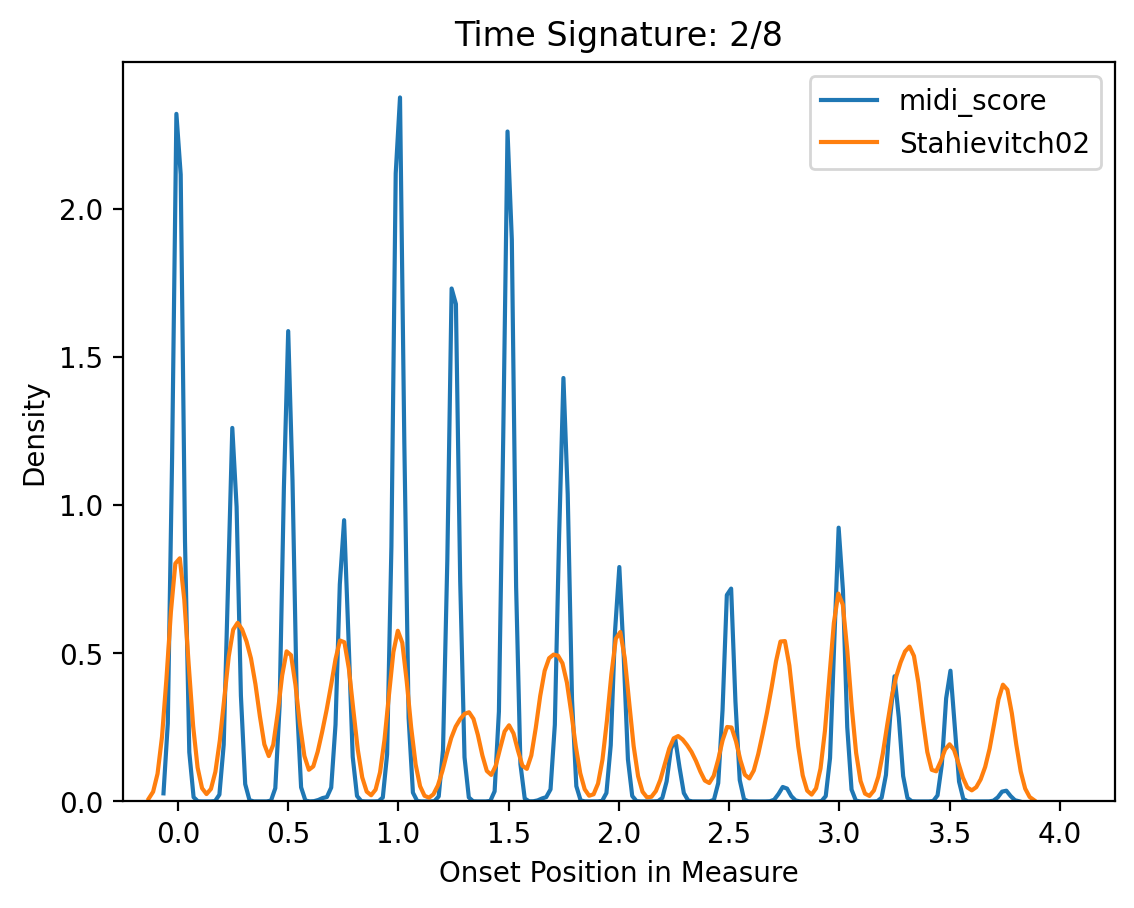

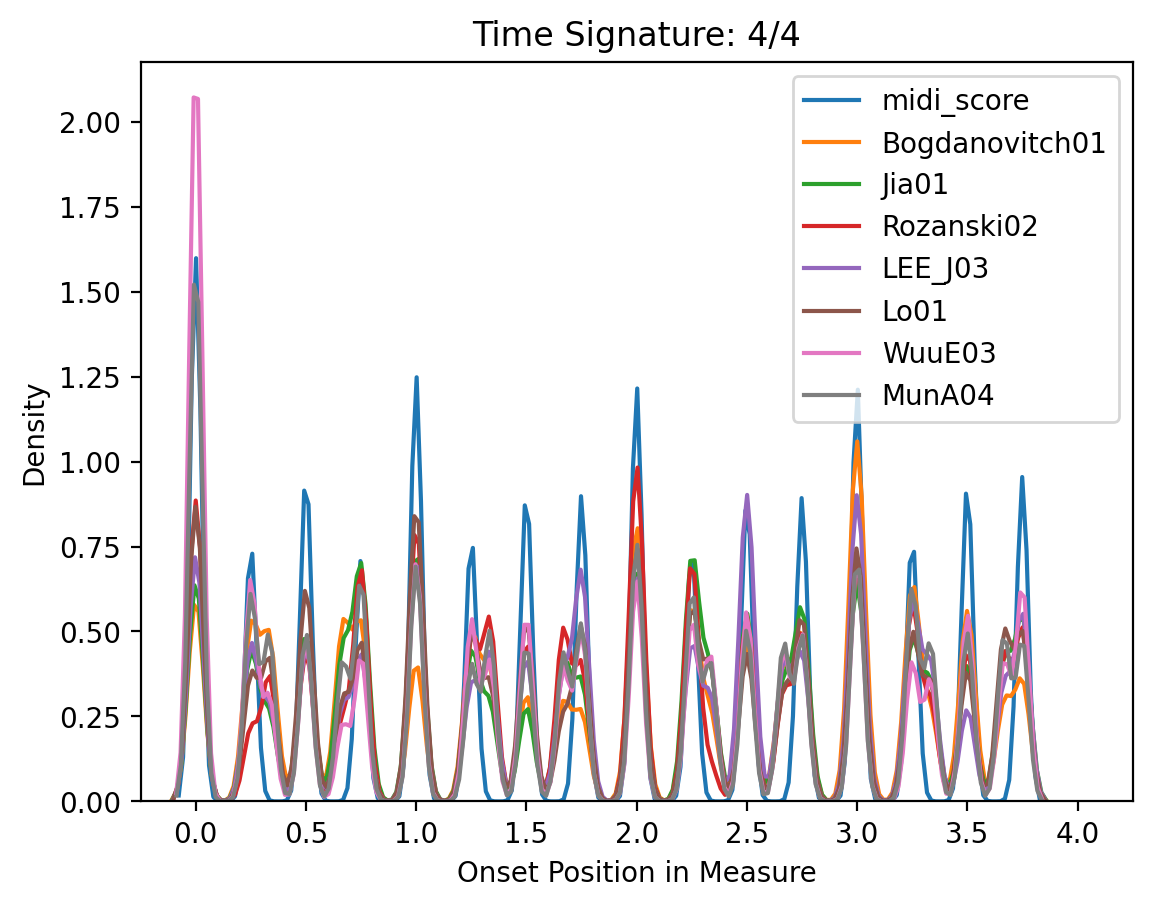

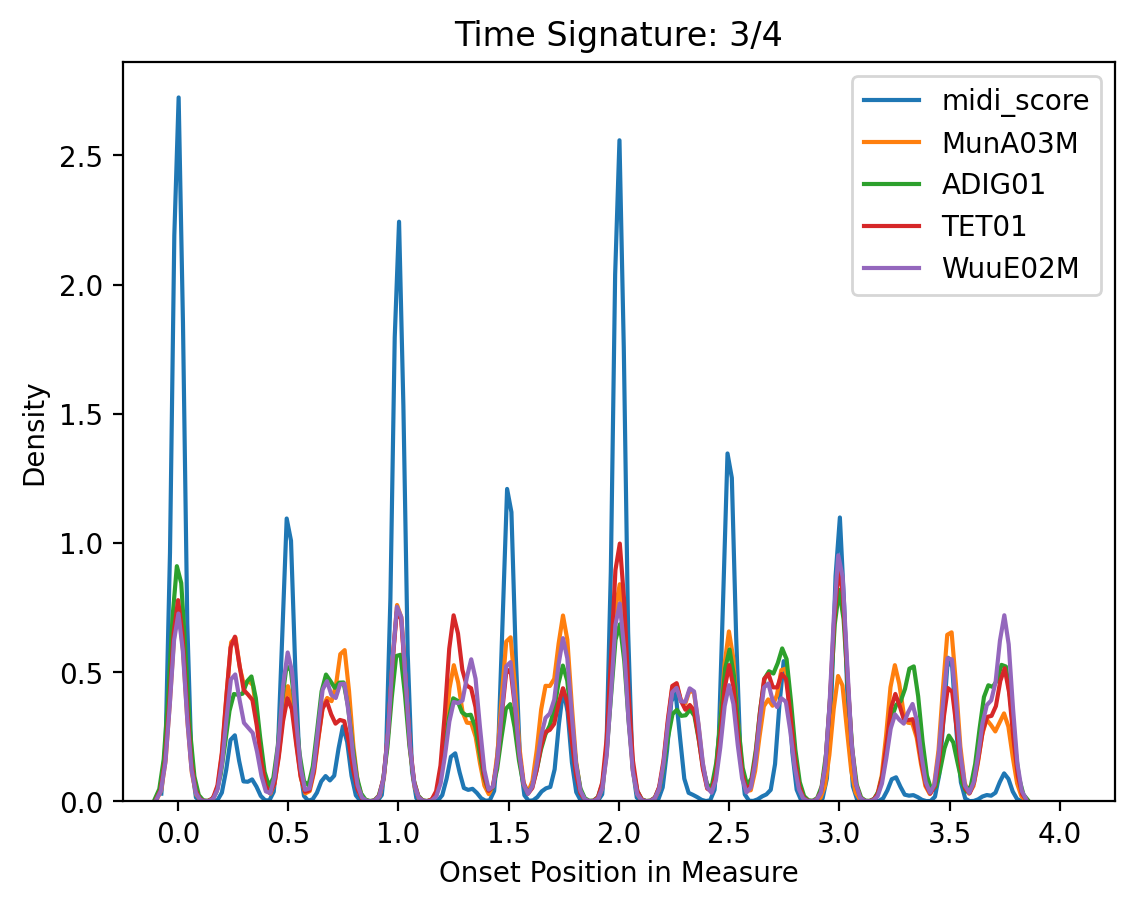

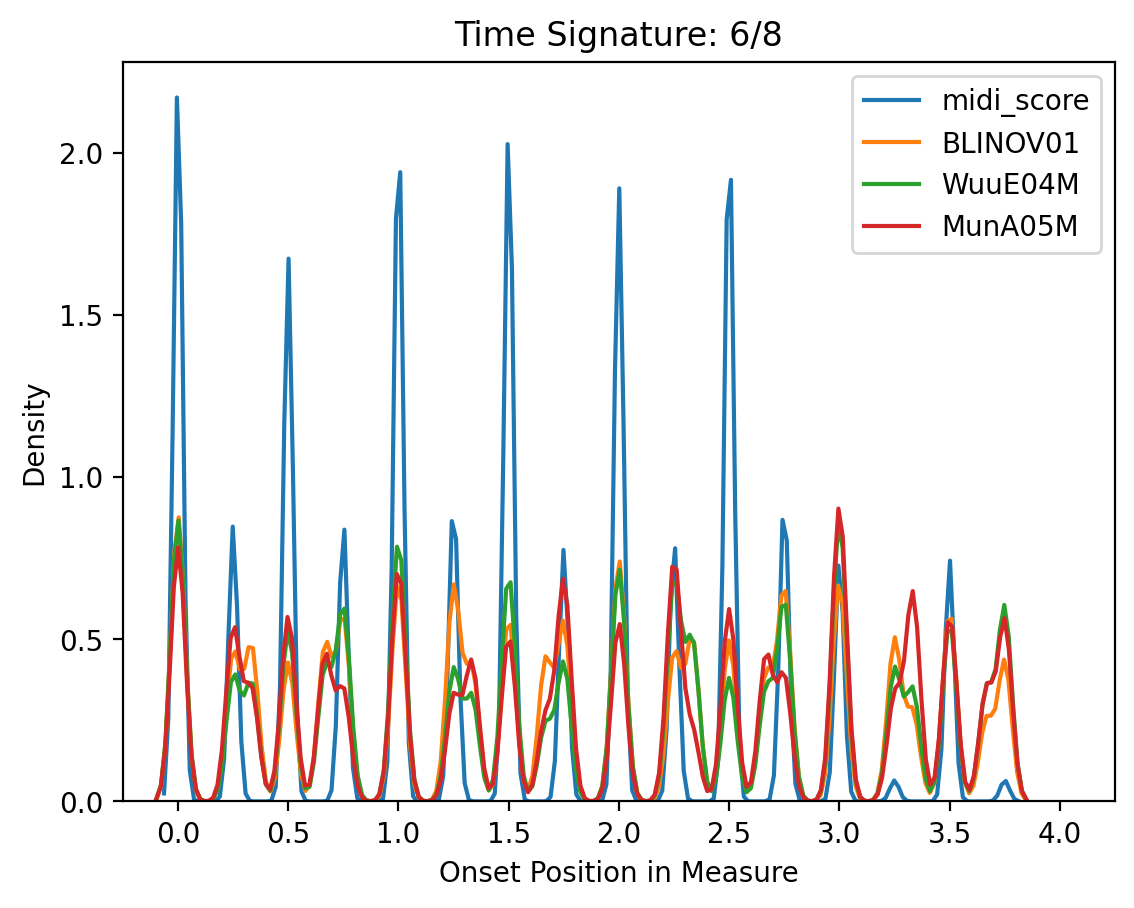

In [16]:
# Initialize a set to store unique time signatures
plotted_signatures = set()

# Iterate over keys in rhythm_dfs
for key in rhythm_dfs.keys():
    # Extract the time signature from the key
    time_signature = key[-2:]

    # Check if the time signature has already been plotted
    if time_signature not in plotted_signatures:
        # Add the time signature to the set of plotted signatures
        plotted_signatures.add(time_signature)

        # Filter keys with the same time signature
        keys_to_plot = [k for k in rhythm_dfs.keys() if k[-2:] == time_signature]

        # Plot distributions for each DataFrame with the same time signature
        for i, k in enumerate(keys_to_plot):
            sns.kdeplot(data=rhythm_dfs[k], x='onset_in_measure', label=k[:-3], bw_adjust=0.1)

        plt.legend()
        plt.xlim(-0.25, 4.25)
        plt.xlabel('Onset Position in Measure')
        plt.title(f"Time Signature: {time_signature[-2]}/{time_signature[-1]}")
        plt.show()